In [ ]:
# Upload kaggle.json file to Colab environment
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

from google.colab import drive
drive.mount("/content/drive")

import os
#Next you need to upload the files to G-Drive
os.chdir("/content/drive/My Drive/DeepLearning project Proposal/")
#!ls /content/drive/My Drive/DeepLearning project Proposal/

Saving kaggle.json to kaggle (1).json
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import time
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi

# Ensure Kaggle credentials are in place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
import os

# Create the directory if it doesn't exist
if not os.path.exists("/root/.config/kaggle"):
    os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move the kaggle.json to the directory
# Upload the kaggle.json file to your notebook's file system
# Replace '/path/to/kaggle.json' with the actual path
# In a Google Colab environment, you might need to manually upload the file
# via the Files panel on the left side of the interface.
# Then copy the path from the file menu options.
if not os.path.exists('/root/.config/kaggle/kaggle.json'):
    shutil.move('./kaggle.json', '/root/.config/kaggle/')


# Change permissions
os.chmod('/root/.config/kaggle/kaggle.json', 600)

# Authenticate and download dataset
api = KaggleApi()
api.authenticate()

# Dataset name and output settings
dataset_name = "imtkaggleteam/dental-radiography"
dataset_zip = "archive.zip"

# Download the dataset
api.dataset_download_files(dataset_name, path=".", unzip=False)

# Wait to ensure download completes
time.sleep(10)

# Check if the dataset is downloaded
if not os.path.exists(dataset_zip):
    raise FileNotFoundError(f"Dataset not downloaded: {dataset_zip}")

# Extract the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dental_radiography")

# Define base directory for the dataset
base_dir = "dental_radiography"

# Define directories for train, valid, and test
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Define output directory
output_dir = "processed_dataset"

# Create output directories
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "valid"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)

# Function to move images based on annotations
def move_images(data_dir, output_data_dir):
    annotations_path = os.path.join(data_dir, "_annotations.csv")
    if not os.path.exists(annotations_path):
        raise FileNotFoundError(f"Annotations file not found at {annotations_path}")

    annotations = pd.read_csv(annotations_path)

    for _, row in annotations.iterrows():
        src_path = os.path.join(data_dir, row['filename'])
        class_folder = os.path.join(output_data_dir, row['class'])
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(src_path, class_folder)

# Move images for train, valid, and test sets
move_images(train_dir, os.path.join(output_dir, "train"))
move_images(valid_dir, os.path.join(output_dir, "valid"))
move_images(test_dir, os.path.join(output_dir, "test"))

print("Dataset organized into train, valid, and test folders.")

# Count images in each directory (optional)
def count_images(directory):
    image_count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_count += 1
    return image_count

train_image_count = count_images(os.path.join(output_dir, "train"))
valid_image_count = count_images(os.path.join(output_dir, "valid"))
test_image_count = count_images(os.path.join(output_dir, "test"))

print(f"Number of images in train_dir: {train_image_count}")
print(f"Number of images in valid_dir: {valid_image_count}")
print(f"Number of images in test_dir: {test_image_count}")

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/imtkaggleteam/dental-radiography
Dataset organized into train, valid, and test folders.
Number of images in train_dir: 1925
Number of images in valid_dir: 204
Number of images in test_dir: 117


In [ ]:
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical

#Load annotations for the training data
train_annotations_path = os.path.join("dental_radiography","train","_annotations.csv")
annotations = pd.read_csv(train_annotations_path)

#Map labels to indices
class_mapping = {'cavity': 0, 'filings': 1, 'impacted_tooth':2, 'implant':3}
annotations['class_idx'] = annotations['class'].map(class_mapping)

#Handle NaN values in class_idx
#Replacing NaN values with a valid class_index(eg:0) or dropping rows with NaN values
annotations['class_idx']=annotations['class_idx'].fillna(0).astype(int) # Replace NaN with 0 and ensure integer type


#Split data into features(X) and labels(y)
X = annotations['filename'] #Filename column contains image paths
y = to_categorical(annotations['class_idx'], num_classes=4)

In [ ]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (Previous code for downloading and organizing the dataset)

# Correct paths for data generators
train_dir = os.path.join("processed_dataset", "train")
valid_dir = os.path.join("processed_dataset", "valid")
test_dir = os.path.join("processed_dataset", "test")
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,

    class_mode='categorical')


Found 1925 images belonging to 4 classes.
Found 204 images belonging to 4 classes.
Found 117 images belonging to 4 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4081 - loss: 1.3506 - val_accuracy: 0.4740 - val_loss: 1.2225
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 1.3542 - val_accuracy: 0.5000 - val_loss: 1.1772
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4523 - loss: 1.2390 - val_accuracy: 0.4792 - val_loss: 1.2027
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4688 - loss: 1.2750 - val_accuracy: 0.4167 - val_loss: 1.4586
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4610 - loss: 1.2378 - val_accuracy: 0.4844 - val_loss: 1.2173
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4375 - loss: 1.1873 - val_accuracy: 0.3333 - val_loss: 1.3339
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.4589 - loss: 1.2376 - val_accuracy: 0.4844 - val_loss: 1.2196
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4688 - loss: 1.2948 - val_accuracy: 0.3333 - val_loss: 1.3252
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4357 - loss: 1.2542 - val_accuracy: 0.4792 - val_loss: 1.2161
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.2122 - val_accuracy: 0.4167 - val_loss: 1.291

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.4615 - loss: 1.2165
Test Loss: 1.2085180282592773
Test Accuracy: 0.4871794879436493


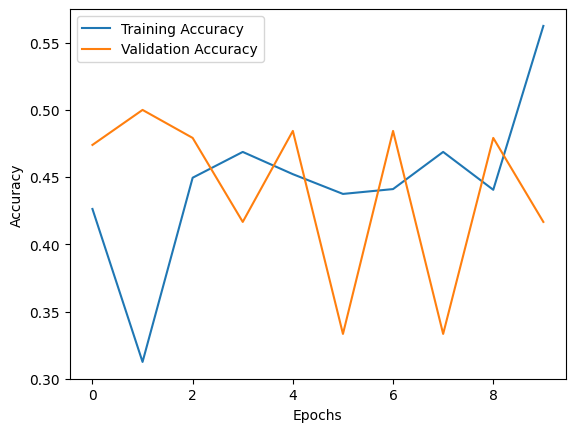

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


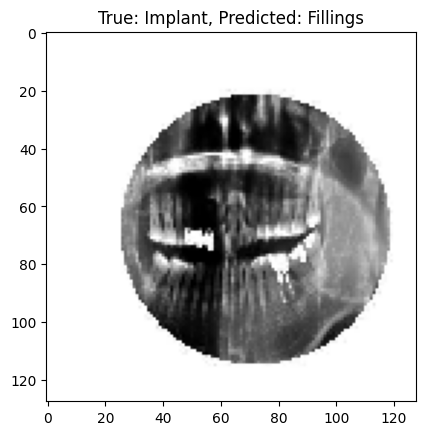

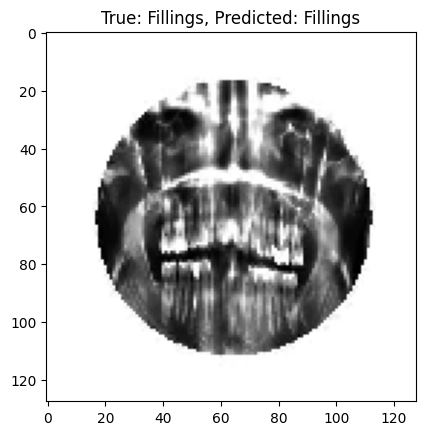

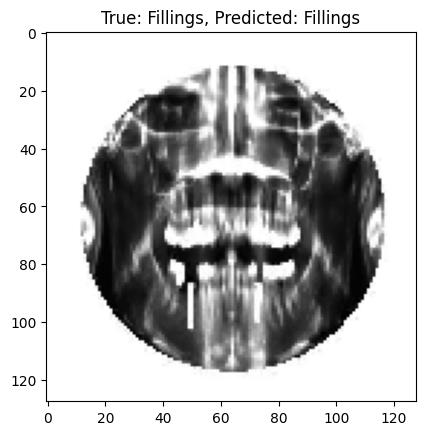

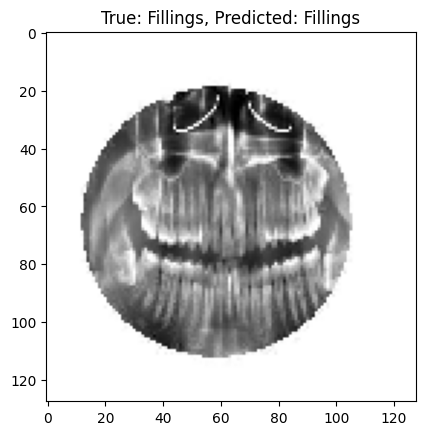

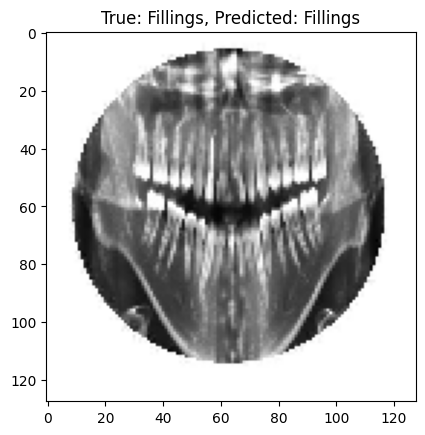

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (your existing code for data loading, model creation, and training)

# Load annotations for the test set (from test_dir)
test_annotations_path = os.path.join("dental_radiography", "test", "_annotations.csv")
test_annotations = pd.read_csv(test_annotations_path)

# Create a mapping from filename to class label in the test set
filename_to_class = dict(zip(test_annotations['filename'], test_annotations['class']))

# Predict on test images
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)

# Visualize predictions
for i in range(5):  # Display predictions for 5 images
    plt.imshow(test_images[i])

    # Get the filename of the current image from the test generator
    image_filename = test_generator.filenames[test_generator.index_array[i]]

    # Get the true and predicted labels
    true_label = filename_to_class.get(os.path.basename(image_filename)) # Get true label from filename
    predicted_label_index = np.argmax(predictions[i])  # Get predicted label index

    # Assuming your class indices are 0, 1, 2, 3...
    predicted_label = test_annotations['class'].unique()[predicted_label_index]


    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.show()

"""In conclusion, This project aimed to classify dental images into specific categories using advanced deep learning models like VGG16 and ResNet50 and also 1 Sequential model built on Keras
Through data augmentation, preprocessing, and fine-tuning of pre-trained networks, the models were trained to capture essential features from the dataset
while ensuring robust generalization.                                         Sequential model built on keras,  had training accuracy average % of around 50% and validation accuracy average % of around 50% and during image prediction it was able to detect 4/5 images accurately
 """